In [10]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import END, START
from langgraph.graph.state import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage
import os
from dotenv import load_dotenv
load_dotenv()

True

In [11]:
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["LANGSMITH_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGSMITH_TRACING"]="true"


In [12]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="llama-3.1-8b-instant")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001EE6234D950>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001EE6234E350>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [13]:
class State(TypedDict):
    messages:Annotated[list[BaseMessage],add_messages]

In [14]:
## Graph With tool Call
from langchain_core.tools import tool

@tool
def add(a:float,b:float):
    """Add two number"""
    return a+b
tools=[add]
tool_node=ToolNode([add])

llm_with_tool=llm.bind_tools([add])

def call_llm_model(state:State):
    return {"messages":[llm_with_tool.invoke(state['messages'])]}


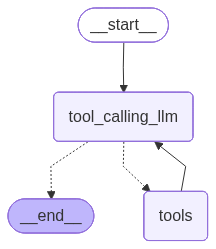

In [15]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def call_llm_model(state:State):
    return {"messages":[llm_with_tool.invoke(state['messages'])]}
## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",call_llm_model)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
response=graph.invoke({"messages":"What is machine learning"})
response

{'messages': [HumanMessage(content='What is machine learning', additional_kwargs={}, response_metadata={}, id='1055646c-ff49-4d95-9cf8-236d35dabc96'),
  AIMessage(content='<function=brave_search>{"query": "machine learning definition"}', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 216, 'total_tokens': 231, 'completion_time': 0.024792105, 'prompt_time': 0.014086038, 'queue_time': 0.055846781, 'total_time': 0.038878143}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_8a13dfab2b', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--bc61a5c8-3910-48e5-bdd8-eaf1586b4131-0', usage_metadata={'input_tokens': 216, 'output_tokens': 15, 'total_tokens': 231})]}

In [17]:
response=graph.invoke({"messages":"what is 5 plus 20"})
response

{'messages': [HumanMessage(content='what is 5 plus 20', additional_kwargs={}, response_metadata={}, id='a51a51e6-8102-4bfd-a623-9d9cc846acaf'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'qap5pe3ad', 'function': {'arguments': '{"a":5,"b":20}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 219, 'total_tokens': 237, 'completion_time': 0.035704387, 'prompt_time': 0.014140036, 'queue_time': 0.055475944, 'total_time': 0.049844423}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_8804b970d6', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--4e315283-4ea8-44da-bd3e-48022f533bdd-0', tool_calls=[{'name': 'add', 'args': {'a': 5, 'b': 20}, 'id': 'qap5pe3ad', 'type': 'tool_call'}], usage_metadata={'input_tokens': 219, 'output_tokens': 18, 'total_tokens': 237}),
  ToolMessage(content='25.0', name='add', id='d712d524-ddc0-4f92-a959-16dd3b63e85e', tool_cal